# EDA

## Imports

In [2]:
import os
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
import fastai

## Basic Reading & Statistics

In [ ]:
# read csvs
train_df = pd.read_csv('dataset_FER/train.csv')
test_df = pd.read_csv('dataset_FER/test.csv')

In [ ]:
train_df.head()

,emotion,Usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [ ]:
test_df.head()

,pixels
0,254 254 254 254 254 249 255 160 2 58 53 70 77 ...
1,156 184 198 202 204 207 210 212 213 214 215 21...
2,69 118 61 60 96 121 103 87 103 88 70 90 115 12...
3,205 203 236 157 83 158 120 116 94 86 155 180 2...
4,87 79 74 66 74 96 77 80 80 84 83 89 102 91 84 ...


In [ ]:
# test_df.columns
train_df.columns

Index(['emotion', ' Usage', ' pixels'], dtype='object')

🦄 **Rename columns to remove extra spaces at the beginning...**

In [ ]:
# rename columns in train_df
train_df.columns = ['emotion', 'usage', 'pixels']
# save train_df to csv
train_df.to_csv('dataset_FER/renamed_train.csv', index=False)
# open and read renamed_train.csv
train_df = pd.read_csv('dataset_FER/renamed_train.csv')
# check the first 5 rows of train_df
train_df.head()

,emotion,usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [ ]:
len_train_df, len_test_df = len(train_df), len(test_df)
print(f"#samples train: {len_train_df}\n#samples test: {len_test_df}")
print(f"-----------------------\nTotal samples: {len_train_df + len_test_df}\n-----------------------")

#samples train: 35887
#samples test: 7178
-----------------------
Total samples: 43065
-----------------------


In [ ]:
train_split = len_train_df / (len_train_df + len_test_df) * 100.
test_split = 100 - train_split
print("-----------------------")
print(f"Split %\n-----------------------\ntraining: {train_split:.3f}%\ntest: {test_split:.3f}%")

-----------------------
Split %
-----------------------
training: 83.332%
test: 16.668%


### Visualizing A random sample from train & test sets

In [10]:
class2emotion = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
emotion2class = dict((v,k) for k,v in class2emotion.items())
# emotion2class, class2emotion

In [ ]:
# get a random row from train_df
train_sample = train_df.sample()
train_sample

,emotion,usage,pixels
5763,0,Training,1 30 98 117 115 86 44 43 65 120 128 99 85 82 7...


In [ ]:
train_id = train_sample.index.values[0]
emotion = train_sample['emotion'].values[0]
usage = train_sample['usage'].values[0]
pixels = train_sample['pixels'].values[0].split(' ')

print("train_id:", train_id,
        "\nemotion:", class2emotion[emotion],
        "\nusage:", usage,
        "\ntotal_pixels:", len(pixels))

assert len(pixels) == 48*48, "[!] total pixels should be 48 * 48"

train_id: 5763 
emotion: Angry 
usage: Training 
total_pixels: 2304


In [ ]:
# create a 48 x 48 image from pixels list (row major ordering RMO)
def create_image_from_rmo_list(pixel_lst):
    img = np.zeros((48, 48), dtype=np.uint8)
    for i in range(48):
        for j in range(48):
            img[i][j] = int(pixel_lst[i * 48 + j])
    return img

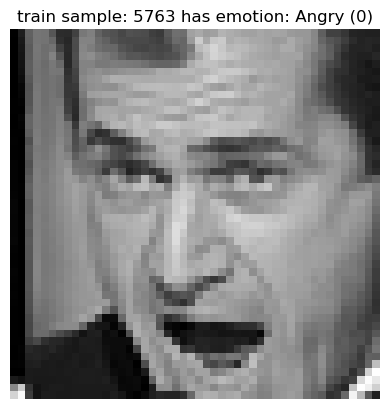

In [ ]:
train_sample_img = create_image_from_rmo_list(pixels)

plt.title(f"train sample: {train_id} has emotion: {class2emotion[emotion]} ({emotion})")
plt.axis(False)
plt.imshow(train_sample_img, cmap='gray')
plt.show()

🦄 **Need to populate dataset with images for grid visualizations...**   
🦄 **Vision models exploit spatial features so need to feed in images anyways...**

In [ ]:
%time
os.system('./utils/csv_to_imgs.py')

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs
Saving train images...


  1%|▏         | 107/7178 [00:00<00:06, 1062.31it/s]

Saving test images...


100%|██████████| 7178/7178 [00:07<00:00, 967.86it/s] 


0

🦄 **Also created a training annotations file!**

In [ ]:
! ls dataset_FER/train/ | wc -l
! ls dataset_FER/test/ | wc -l

35887
7178


In [3]:
from fastai.vision.all import *

In [4]:
train_files = get_image_files("dataset_FER/train")
test_files = get_image_files("dataset_FER/test")
len(train_files), len(test_files)

(35887, 7178)

In [13]:
def label_func(file_name):
    # extract index from file name
    indX = file_name.split('/')[-1].split('.')[0]
    # get label from annotation file
    with open('dataset_FER/train_annotations.txt', 'r') as f:
        labels = f.readline()
        return class2emotion[int(labels[int(indX)])]
    return -1


In [14]:
dls = ImageDataLoaders.from_name_func(".", train_files, label_func, item_tfms=Resize(224))

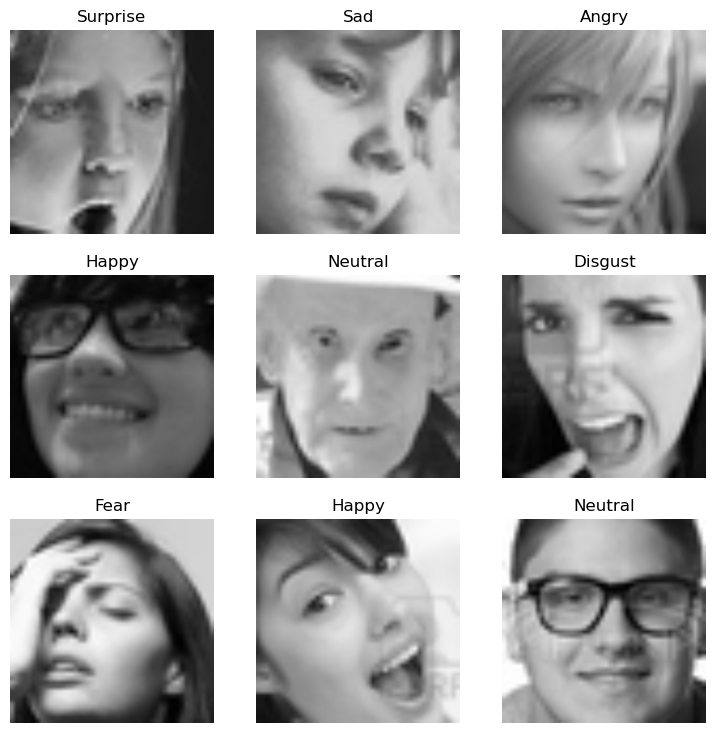

In [15]:
dls.show_batch()